In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [4]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [25]:
x_range = (1.5, 3)
y_range = (-0.4, .5)
figsize = (14,8)

## Lennard-Jones potential

$ V_{\text{LJ}}=4\varepsilon \left[\left({\frac {\sigma }{r}}\right)^{12}-\left({\frac {\sigma }{r}}\right)^{6}\right]=\varepsilon \left[\left({\frac {r_{min}}{r}}\right)^{12}-2\left({\frac {r_{min}}{r}}\right)^{6}\right],$

where 
- r is the distance between the particles, 
- ε is the depth of the potential well, 
- $r_{min}$ is the distance at which the potential reaches its minimum.
- σ is the finite distance at which the inter-particle potential is zero, 


In [26]:
class LennardJones(object):
    def __init__(self, ε, r_min):
        self.ε = ε
        self.r_min = r_min

    def __call__(self, r):
        return self.ε * ((self.r_min/r)**12 - 2*(self.r_min/r)**6)

In [27]:
V = LennardJones(ε=.25, r_min=2)
x = np.linspace(*x_range, 1000)

In [28]:
rng = np.random.RandomState(115)
X = rng.normal(loc=2.1, scale=.2, size=5)
Y =  V(X)

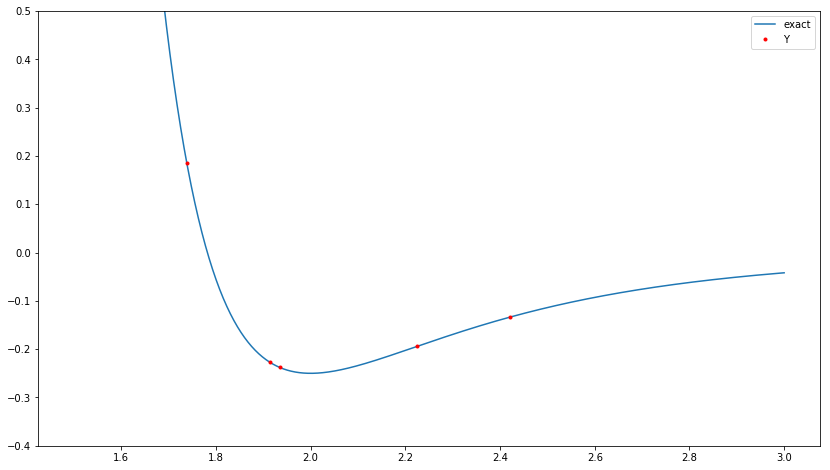

In [29]:
plt.figure(figsize=figsize)

plt.plot(x, V(x), label='exact')
plt.plot(X, Y, 'r.', label='Y')

plt.ylim(y_range)
plt.legend()
plt.show()

In [30]:
length_scale = 0.25
noise = 1e-4

kernel = 1.0 * RBF(length_scale=length_scale, length_scale_bounds=(1e-2, 1e3))

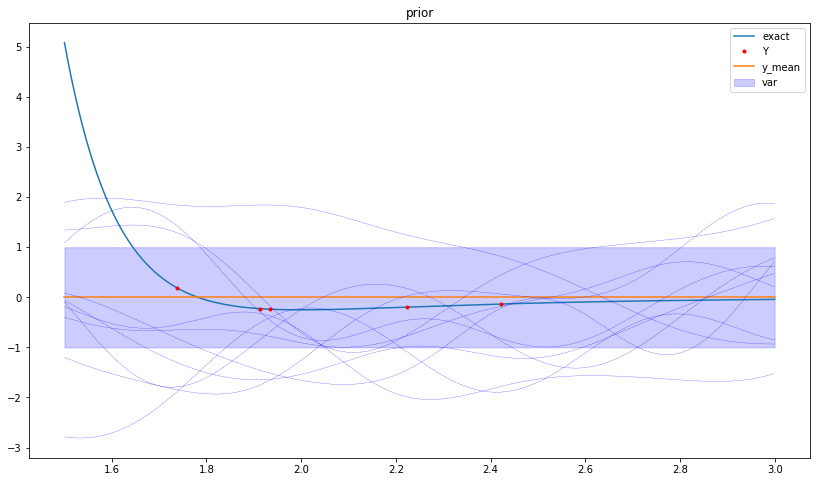

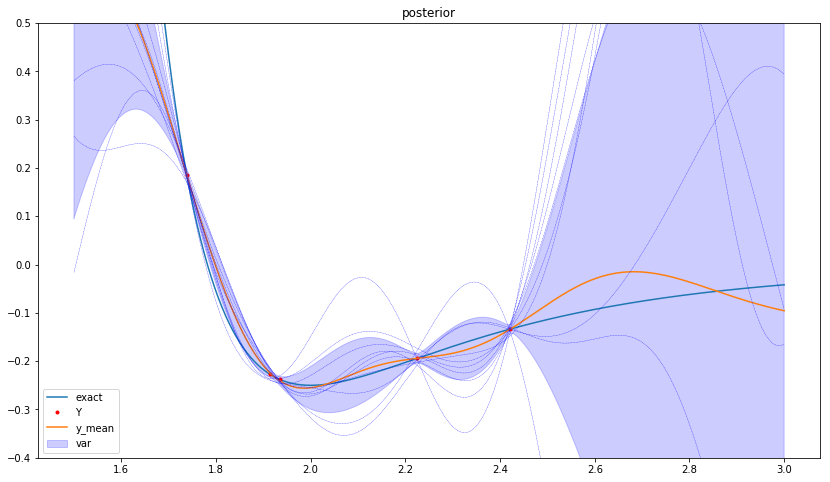

In [31]:
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise, normalize_y=True, optimizer=None)

y_mean, y_std = gp.predict(x.reshape(-1,1), return_std=True)
y_samples = gp.sample_y(x.reshape(-1,1), 10)

plt.figure(figsize=figsize)
plt.plot(x, V(x), label='exact')
plt.plot(X, Y, 'r.', label='Y')
plt.plot(x, y_mean, label='y_mean')

plt.fill_between(x, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='b', label='var')

plt.plot(x, y_samples, linewidth=.3, color='b', ls = '--')

# plt.ylim(y_range)
# plt.ylim(y_range)
plt.legend()
plt.title('prior')
plt.show()

gp.fit(X.reshape(-1, 1), Y)

y_mean, y_std = gp.predict(x.reshape(-1,1), return_std=True)
y_samples = gp.sample_y(x.reshape(-1,1), 10)

plt.figure(figsize=figsize)
plt.plot(x, V(x), label='exact')
plt.plot(X, Y, 'r.', label='Y')
plt.plot(x, y_mean, label='y_mean')

plt.fill_between(x, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='b', label='var')

plt.plot(x, y_samples, linewidth=.3, color='b', ls = '--')

plt.ylim(y_range)
plt.legend()
plt.title('posterior')
plt.show()


In [35]:
class model(object):
    def __init__(self, x_train, y_train, length_scale, noise):
        self.x_train = x_train
        self.y_train = y_train
        
        self.length_scale = length_scale
        self.noise = noise
        
        self.gp = GaussianProcessRegressor(
            kernel=1.0*RBF(length_scale=length_scale),
            alpha=noise, 
            normalize_y=False, 
            optimizer=None
        )
        
        self.gp.fit(self.x_train.reshape(-1, 1), self.y_train)

    def predict(self, x):
        y_mean, y_std = self.gp.predict(x.reshape(-1,1), return_std=True)
        return y_mean, y_std 
    
    def samples(self, x, n=10):
        y_samples = self.gp.sample_y(x.reshape(-1,1), n)
        return y_samples
    
    def kernels(self, x):
        # plt.plot(x,np.sum(gp.alpha_ * gaussian(x, gp.X_train_, length_scale).T, axis=1) + gp._y_train_mean)
        kernels = self.y_train * self.gaussian(x.reshape(-1,1), self.x_train, self.length_scale)
        return kernels

    @staticmethod
    def gaussian(x, mu, sigma): 
        # return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
        return np.exp( -(x - mu)**2 / (2 * sigma**2))


In [36]:
def plot_gp(x, v, x_train, y_train, y_mean):

    plt.plot(x, v, label='exact')
    plt.plot(x_train, y_train, 'r.', label='train set')
    plt.plot(x, y_mean, label='predicted')
    
    
def plot_gp_interval(x, v, x_train, y_train, y_mean, y_std):
    plot_gp(x, v, x_train, y_train, y_mean)
    
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k', label='conf interval')

    plt.ylim(y_range)
    plt.legend()
    plt.show()

def plot_gp_samples(x, v, x_train, y_train, y_mean, y_samples):
    plot_gp(x, v, x_train, y_train, y_mean)
    
    plt.plot(x, y_samples, linewidth=.5)
    
    plt.ylim(y_range)
    plt.legend()
    plt.show()

def plot_gp_kernels(x, v, x_train, y_train, y_mean, y_kernels):
    plot_gp(x, v, x_train, y_train, y_mean)
    
    plt.plot(x, y_kernels)

    plt.ylim(y_range)
    plt.legend()
    plt.show()



In [37]:
x = np.linspace(*x_range, 1000)
V = LennardJones(ε=.25, r_min=2)
v = V(x)

@interact(
    n_train=(1,20), 
    system_noise=(0.0,.05, 0.01), 
    length_scale=(0.05,.55), 
    noise=widgets.FloatLogSlider(
        value=1e-3,
        min=-5, # max exponent of base
        max=-2, # min exponent of base
        step=1, # exponent step
    ), 
    plot_type=widgets.ToggleButtons(
            options=['interval', 'samples', 'kernels'],
            description='',
        )) 
def main_interact(n_train=5, system_noise=.0, length_scale=0.4, noise=-4, plot_type='interval'):
    
    rng = np.random.RandomState(111)
    x_train = rng.normal(loc=2.1, scale=.2, size=n_train)
    y_train = V(x_train) + rng.normal(loc=0, scale=system_noise, size=n_train)

    m = model(x_train, y_train, length_scale, noise)
    y_mean, y_std = m.predict(x)
    
    plt.figure(figsize=figsize)
    if plot_type=='interval':
        plot_gp_interval(x, v, x_train, y_train, y_mean, y_std)
    elif plot_type=='samples':
        y_samples = m.samples(x)
        plot_gp_samples(x, v, x_train, y_train, y_mean, y_samples)
    elif plot_type=='kernels': 
        y_kernels = m.kernels(x)
        plot_gp_kernels(x, v, x_train, y_train, y_mean, y_kernels)


interactive(children=(IntSlider(value=5, description='n_train', max=20, min=1), FloatSlider(value=0.0, descrip…